In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

path = os.getcwd()
for _ in range(2):
    path = os.path.dirname(path)

if not path in sys.path:
    sys.path.append(path)

In [13]:
import torch
import pytorch_lightning as pl
import os
import ModelFusion.helpers.pytorch_utils as ptu

from ModelFusion.helpers.load_data import load_data
from ModelFusion.helpers.load_model import load_model, reload_model
from ModelFusion.helpers.pl_helpers import TrainSeg, get_logger
from ModelFusion.helpers.pl_callbacks import ValVisualizationSeg
from pytorch_lightning.callbacks import ModelCheckpoint
from monai.utils import CommonKeys
from ModelFusion.helpers.utils import vis_images

In [7]:
ds_name = "MNMS"
vendor = "A"
model_name = "UNet"
save_dir = "../"
log_name = "seg_logs"
if_debug = False
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

## 1. Read Data

In [5]:
# for mode in ["val", "test"]:
#     for vendor in ["A", "B", "C", "D"]:
#         if mode == "train" and vendor == "D":
#             continue
#         for if_aug in [True, False]:
#             print(f"current: {mode}, {vendor}, {if_aug}")
#             ds = load_data(ds_name, mode, vendor=vendor, if_aug=if_aug)
#             print(f"{ds[0][CommonKeys.IMAGE].shape}, {ds[0][CommonKeys.LABEL].shape}")
#             print("-" * 100)

In [6]:
train_ds = load_data(ds_name, "train", vendor=vendor)
val_ds = load_data(ds_name, "val", vendor=vendor)

Loading dataset: 100%|███████████████████████████████████████| 104/104 [00:00<00:00, 150.52it/s]


## 2. Load Model

In [7]:
X_test = train_ds[0][CommonKeys.IMAGE].unsqueeze(0)
for model_name in ["UNet", "SwinUNETR"]:
    model = load_model(model_name)
    pred = model(X_test)
    print(f"{model_name}: output shape {pred.shape}")
    print("-" * 100)

UNet: output shape (1, 4, 256, 256)
----------------------------------------------------------------------------------------------------
SwinUNETR: output shape (1, 4, 256, 256)
----------------------------------------------------------------------------------------------------


## 3. Training

In [8]:
ds_dict = {
    "train": train_ds,
    "val": val_ds
}
model = load_model(model_name)
lit_model = TrainSeg(ds_dict, model)

In [9]:
logger, time_stamp = get_logger(save_dir, log_name)
callbacks = [
    ValVisualizationSeg(save_interval=1),
    ModelCheckpoint(os.path.join(save_dir, log_name, time_stamp, "checkpoints/"), monitor="val_dsc", mode="max")
]

In [10]:
# if_debug = True
if if_debug:
    trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        fast_dev_run=2
    )
else:
    trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        logger=logger,
        callbacks=callbacks,
        num_sanity_val_steps=-1,
#         precision=16,
#         max_epochs=lit_model.num_epochs,
        max_epochs=5
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(lit_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | model   | SwinUNETR  | 6.3 M 
1 | loss_fn | DiceCELoss | 0     
---------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.183    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

D:\python\venvs\IML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
D:\python\venvs\IML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

D:\python\venvs\IML\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## 4. Reload Model

In [6]:
log_dir = "../seg_logs/2022_11_13_00_51_38_384949/"

In [9]:
train_ds = load_data(ds_name, "train", vendor=vendor)
val_ds = load_data(ds_name, "val", vendor=vendor)

Loading dataset: 100%|███████████████████████████████████████| 104/104 [00:00<00:00, 136.24it/s]


In [11]:
model_reload = reload_model(model_name, log_dir)

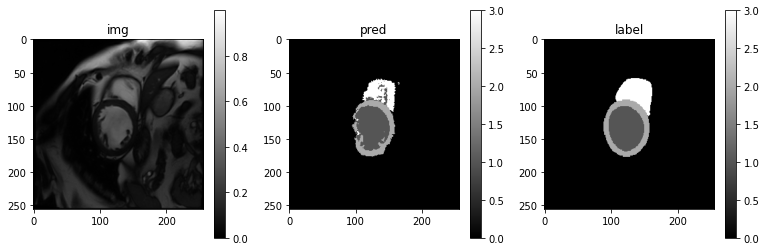

In [17]:
with torch.no_grad():
    idx = 10
    data = val_ds[idx]
    img, label = data[CommonKeys.IMAGE], data[CommonKeys.LABEL]
    img_input = img.unsqueeze(0).to(ptu.DEVICE)
    pred = model_reload(img_input).detach().cpu().argmax(dim=1, keepdim=True).squeeze(0)

vis_images(img, pred, label, titles=["img", "pred", "label"])